# Exploring Mental Health Discourse on Reddit (Tokenization, Normalization, and Descriptive Statistics)

This notebook explores textual data extracted from Reddit posts related to mental health. It focuses on preprocessing techniques such as tokenization and normalization to prepare the text for analysis. The goal is to gain a deeper understanding of how mental health topics are discussed on Reddit through comprehensive text analysis.

### Import Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

from textblob import TextBlob

from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

from collections import Counter
from joblib import Parallel, delayed
from gensim import corpora

import string 
from string import punctuation

import os
import datetime
import time
import re
import requests
import random
import praw

# supress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# import data 
df = pd.read_csv('data/reddit_posts.csv')
mental_health_support_df = pd.read_csv('data/mental_health_support_posts.csv')
mental_health_df = pd.read_csv('data/mental_health_posts.csv')

In [4]:
df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,158,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,159.595960,1.595960,0.003447
1,What changes your negative thoughts/ has made ...,43,0.98,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,43.877551,0.877551,0.000948
2,what is the point of living?,44,0.92,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.826087,3.826087,0.001033
3,I need a hug,22,0.9,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,24.444444,2.444444,0.000528
4,What are you like after a hug,22,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,22.680412,0.680412,0.000490


In [5]:
mental_health_support_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,158,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,159.595960,1.595960,0.003447
1,What changes your negative thoughts/ has made ...,43,0.98,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,43.877551,0.877551,0.000948
2,what is the point of living?,44,0.92,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.826087,3.826087,0.001033
3,I need a hug,22,0.9,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,24.444444,2.444444,0.000528
4,What are you like after a hug,22,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,22.680412,0.680412,0.000490


In [6]:
mental_health_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,My daughter is scaring me tonight. No idea how...,922,0.98,2023-12-09 02:50:29,My daughter (10) very suddenly this evening sa...,mentalhealth,ajgl1990,False,/r/mentalhealth/comments/18e3pnh/my_daughter_i...,246,940.816327,18.816327,0.002006
1,Brain cancer at 16… I’m a mess now.,829,0.98,2023-11-10 22:18:46,Became extremely I’ll at 16 and told my mom “t...,mentalhealth,Intelligent_Pipe7980,False,/r/mentalhealth/comments/17sfgi8/brain_cancer_...,88,845.918367,16.918367,0.001803
2,I did it. I graduated. I didn’t let depression...,825,0.99,2023-06-14 15:15:05,Depression took over but I won.,mentalhealth,No_Panic2551,False,/r/mentalhealth/comments/149ah8y/i_did_it_i_gr...,137,833.333333,8.333333,0.001777
3,Date raped and now pregnant and I’m just so sad,725,0.94,2023-11-25 04:06:49,I’ve never been to therapy despite a bunch of ...,mentalhealth,Sensitive_World7780,False,/r/mentalhealth/comments/183b3u5/date_raped_an...,61,771.276596,46.276596,0.001644
4,I killed myself on Monday and feel like I will...,662,0.97,2023-07-02 12:58:41,"I think the title says enough, on Monday I lit...",mentalhealth,Dry_Opportunity8703,False,/r/mentalhealth/comments/14onpo2/i_killed_myse...,127,682.474227,20.474227,0.001455


### Text Preprocessing (Tokenization and Normalization)

In [7]:
# tokenization/normalization 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# function to preprocess text: tokenization, removing stop words, and lemmatization
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [8]:
# apply preprocessing to 'selftext'
df['tokens'] = df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

In [9]:
# descriptive statistics
numerical_stats = df.describe()
token_count_stats = df['tokens'].describe()

# most common words
all_tokens = [token for tokens in df['tokens'] for token in tokens]
fdist = FreqDist(all_tokens)
most_common_words = fdist.most_common(10)

# output statistics for combined df 
print("Numerical Statistics:\n", numerical_stats)
print("\nToken Count Statistics:\n", token_count_stats)
print("\nMost Common Words:\n", most_common_words)

Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers
count   3944.000000  3944.000000  3944.000000          3944.000000
mean      17.514452    31.669105     1.504298             0.000095
std       43.319617    75.437728     4.786048             0.000169
min        0.000000     0.000000     0.000000             0.000000
25%        0.000000     1.000000     0.000000             0.000017
50%        2.000000     2.000000     0.000000             0.000043
75%       13.000000    30.154639     0.813953             0.000109
max      616.000000   940.816327    61.487179             0.003447

Token Count Statistics:
 count     3946
unique    3761
top         []
freq        10
Name: tokens, dtype: object

Most Common Words:
 [('like', 6343), ('feel', 5851), ('know', 3952), ('time', 3279), ('get', 3218), ('want', 3179), ('life', 2952), ('even', 2785), ('thing', 2685), ('really', 2541)]


Common words in the dataset include terms like "like", "feel", "know", and "time", indicating frequent discussion around personal feelings and experiences.

Based on the descriptive statistics provided, we have opted to analyze each subreddit separately for r/MentalHealth and r/MentalHealthSupport. This approach allows for a more focused exploration of each subreddit's unique trends and characteristics. By focusing individually on each subreddit, we can gain deeper insights into specific trends within each subreddit.

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return ""
    # Remove newline characters and excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens into a single string
    cleaned_text = ' '.join(tokens)
    # Remove spaces before punctuation
    cleaned_text = re.sub(r'\s([?.!"](?:\s|$))', r'\1', cleaned_text)
    # Remove trailing punctuation
    cleaned_text = re.sub(r'([?.!"](?:\s|$))', r'\1', cleaned_text)
    return cleaned_text

def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []

In [11]:
mental_health_support_df

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,158,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,159.595960,1.595960,0.003447
1,What changes your negative thoughts/ has made ...,43,0.98,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,43.877551,0.877551,0.000948
2,what is the point of living?,44,0.92,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.826087,3.826087,0.001033
3,I need a hug,22,0.9,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,24.444444,2.444444,0.000528
4,What are you like after a hug,22,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,22.680412,0.680412,0.000490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Why am I so scared of everything?,15,1.0,2024-05-12 16:14:19,"I, (21 F) just finished my college this month ...",MentalHealthSupport,TerribleFish6588,False,/r/MentalHealthSupport/comments/1cqbf7x/why_am...,22.0,15.000000,0.000000,0.000324
1916,Hidden from my family,1,1.0,2024-05-12 10:47:20,My mom hid my existence from my entire extende...,MentalHealthSupport,Business_Berry6374,False,/r/MentalHealthSupport/comments/1cq54bk/hidden...,0.0,1.000000,0.000000,0.000022
1917,Has cbt helped anyone overcome negative though...,6,1.0,2024-05-12 09:26:35,"For years I’ve had negative ways of thinking, ...",MentalHealthSupport,soulliving3,False,/r/MentalHealthSupport/comments/1cq3z3q/has_cb...,4.0,6.000000,0.000000,0.000130
1918,Cognitive Dissonance,4,1.0,2024-05-12 08:44:40,\nSo after a huge blow out my bf has agreed to...,MentalHealthSupport,Crybabycalzone,False,/r/MentalHealthSupport/comments/1cq3dyp/cognit...,3.0,4.000000,0.000000,0.000086


The following code initializes a tokenizer from the 'distilbert-base-uncased' model,

In [12]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# initialize the tokenizer from the Hugging Face library
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# define stopwords and lemmatizer
# define stopwords to filter out common and custom words that do not provide meaningful information
stop_words = set(stopwords.words('english'))
custom_stop_words = set(["ha", "wa","w", "p", "pa", "cl", "pa", "de", "us", "n", "na", "f", "g", "b", "th", "j","un", 
                         "cu" "le", "would", "could", "should", "one", "get", "go", "also", "many", "much",
                         "make", "take", "don", "did", "doesn", "hasn", "hadn", "won", "didn", "aren", "isn", 
                         "weren", "not", "nt", "re", "ve", "m", "ll", "im", "iv", "thing", "wan", "ab", "vi", "www"])

# initialize WordNet lemmatizer for text normalization
lemmatizer = WordNetLemmatizer()

# enhanced preprocess function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Remove apostrophes and commas
    text = re.sub(r"[',]", '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = tokenizer.tokenize(text.lower())
    # Truncate tokens to the maximum length for the model
    tokens = tokens[:512]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words and word not in custom_stop_words]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# sample text
sample_text = """
i randomly came across a news article about a new mental health court & realize the appointed supervising judge ha a history of disregard # # ing court ordered psychiatric testing result & evaluation # # s. the article stated the court this specific judge is supervising is notably le effective than comparable court throughout the state. when you consider the judge career and previous lack of respect for mental health professional evaluation # # s & recommendation it make sense why the court ha been ineffective. i wrote the journalist who wrote the news article & have tried to address concern previously. but i ’ m extremely frustrated & confused a to how could it be a judge who ha a documented record of totally disregard # # ing , not that the judge doesn ’ t agree or want a second opinion , completely disregard # # ing the conclusion & recommendation of licensed mental health professional the court ordered an opinion from. it ’ s mind bog # # g # # ling. the judge who ha thwarted effort to address mental health matter in court is the supervising judge of discussing mental health matter in court. i ’ ve tried to have an official discussion , investigation many time & many way & stopped after getting no where and i didn ’ t imagine that somehow the same judge that resisted taking mental health seriously in any way would become the supervising judge of case in which people are trying to take mental health seriously. that supervising judge ordered an evaluation of someone being accused of having a severe mood disorder , alcoholism , and lying. the evaluation concludes that the accused doe have a mood disorder , ha been and likely to be suicidal , pre # # di # # s # # posed to lying & putting their own want above the need of others including their own child , increased risk of chemical dependency & resistance to comply with court order. the judge then fully disregard # # s the conclusion of a court ordered & appointed psychiatric professional. that person went on to kidnap a child , another du # # i and more that could of been prevented if that judge had shown any respect for the conclusion of mental health professional who ’ s evaluation wa requested by the court. no wonder a news article wa written how out of all california it only sf who ’ s mental health court is notably ineffective. besides the supervising judge the director of public health also ha documented instance of going against what licensed professional have recommended. they ’ re truly openly running a corrupt system for their own profit by only providing service to those who they can continuously profit by recommend # # ing ineffective or inappropriate service and denying any service to those that can be helped until they can funnel the use of mental health
"""

# apply preprocessing
cleaned_sample_text = preprocess_text(sample_text)
print("Cleaned and Tokenized Text:")
print(cleaned_sample_text)

# apply pre-processing to the dataframe
mental_health_support_df['selftext'] = mental_health_support_df['selftext'].astype(str).apply(preprocess_text)
mental_health_df['selftext'] = mental_health_df['selftext'].astype(str).apply(preprocess_text)

# tokenization and stop word removal
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []
    
# convert 'selftext' to string to avoid float issues
mental_health_support_df['selftext'] = mental_health_support_df['selftext'].astype(str)
mental_health_df['selftext'] = mental_health_df['selftext'].astype(str)
    

# apply tokenization and stop word removal in parallel
mental_health_support_df['tokens'] = Parallel(n_jobs=-1)(
    delayed(tokenize_and_remove_stopwords)(text) for text in mental_health_support_df['selftext'])
mental_health_df['tokens'] = Parallel(n_jobs=-1)(
    delayed(tokenize_and_remove_stopwords)(text) for text in mental_health_df['selftext'])

# apply enhanced preprocessing for cleaned text in parallel
mental_health_support_df['selftext'] = Parallel(n_jobs=-1)(
    delayed(preprocess_text)(text) for text in mental_health_support_df['selftext'])
mental_health_df['selftext'] = Parallel(n_jobs=-1)(
    delayed(preprocess_text)(text) for text in mental_health_df['selftext'])

# function for analyzing subreddits
def analyze_subreddit(subreddit_df):
    numerical_stats = subreddit_df.describe()
    token_count_stats = subreddit_df['tokens'].apply(len).describe()
    all_tokens = [token for tokens in subreddit_df['tokens'] for token in tokens]
    most_common_words = Counter(all_tokens).most_common(10)
    return numerical_stats, token_count_stats, most_common_words

# sentiment analysis functions
def get_sentiment_category(sentiment):
    if sentiment['compound'] > 0:
        return 'positive'
    elif sentiment['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

def analyze_sentiments(subreddit_df):
    sid = SentimentIntensityAnalyzer()
    try:
        subreddit_df['sentiment'] = subreddit_df['selftext'].apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) else {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0})
        subreddit_df['sentiment_category'] = subreddit_df['sentiment'].apply(get_sentiment_category)
        sentiment_stats = subreddit_df['sentiment'].apply(lambda x: x['compound']).describe()
        sentiment_category_counts = subreddit_df['sentiment_category'].value_counts()
        print("Sentiment analysis completed successfully.")
        return sentiment_stats, sentiment_category_counts
    except Exception as e:
        print(f"Error during sentiment analysis: {e}")

# function to generate word cloud
def generate_word_cloud(tokens, title):
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis('off')
        plt.show()
        print("Word cloud generated successfully.")
    except Exception as e:
        print(f"Error during word cloud generation: {e}")

# topic modeling function
def topic_modeling(tokens_list, num_topics=5):
    try:
        dictionary = corpora.Dictionary(tokens_list)
        corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        topics = lda_model.print_topics(num_words=10)
        print("Topic modeling completed successfully.")
        return topics
    except Exception as e:
        print(f"Error during topic modeling: {e}")

# time series plot function
def plot_time_series(subreddit_df, title):
    try:
        subreddit_df['created_utc'] = pd.to_datetime(subreddit_df['created_utc'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        subreddit_df.set_index('created_utc', inplace=True)
        monthly_counts = subreddit_df.resample('M').size()
        monthly_counts.plot(figsize=(10, 5), title=title)
        plt.ylabel('Number of Posts')
        plt.show()
        print("Time series plot generated successfully.")
    except Exception as e:
        print(f"Error during time series plot generation: {e}")

Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


Cleaned and Tokenized Text:
randomly came across news article new mental health court realize appointed supervising judge history disregard ing court ordered psychiatric testing result evaluation article stated court specific judge supervising notably le effective comparable court throughout state consider judge career previous lack respect mental health professional evaluation recommendation sense court ineffective wrote journalist wrote news article tried address concern previously extremely frustrated confused judge documented record totally disregard ing judge agree want second opinion completely disregard ing conclusion recommendation licensed mental health professional court ordered opinion mind bog ling judge thwarted effort address mental health matter court supervising judge discussing mental health matter court tried official discussion investigation time way stopped getting imagine somehow judge resisted taking mental health seriously way become supervising judge case people

These initial steps prepare the text data for a variety of natural language processing (NLP) tasks, including sentiment analysis, topic modeling, and more detailed statistical analysis of subreddit content.

## Descriptive Statistics 

### r/MentalHealthSupport subreddit

Sentiment analysis completed successfully.
Topic modeling completed successfully.


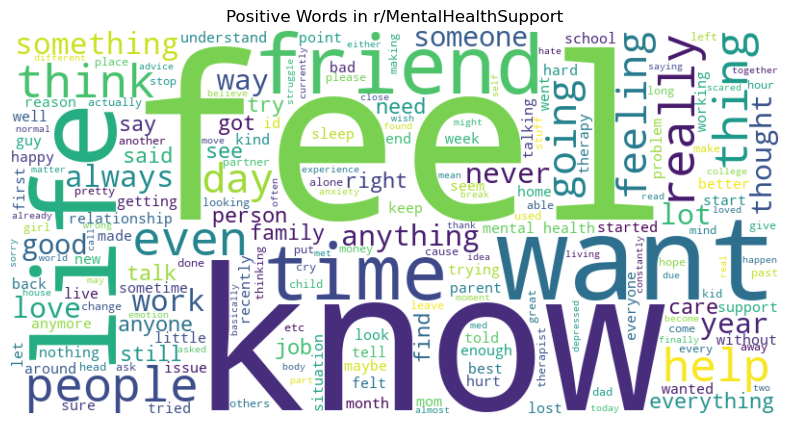

Word cloud generated successfully.


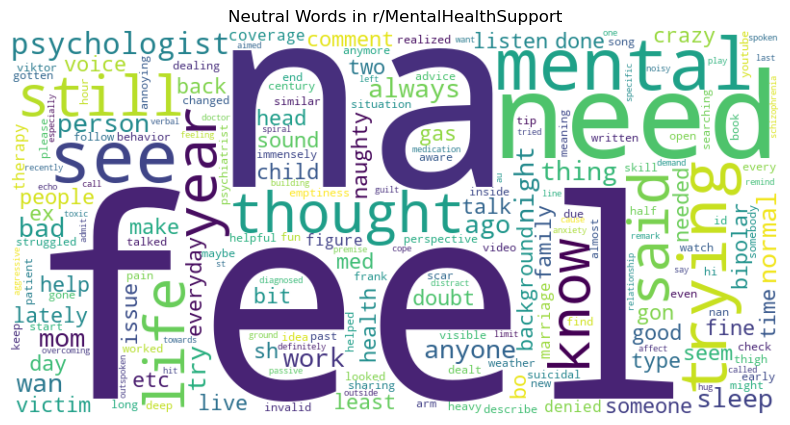

Word cloud generated successfully.


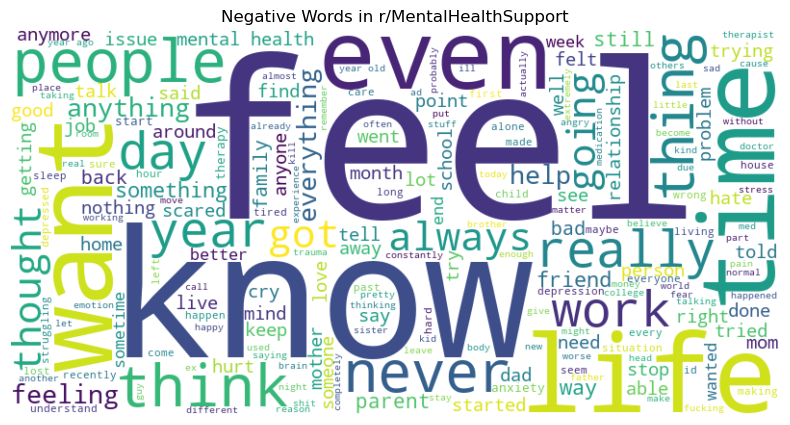

Word cloud generated successfully.


/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_1833/760322041.py:130: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


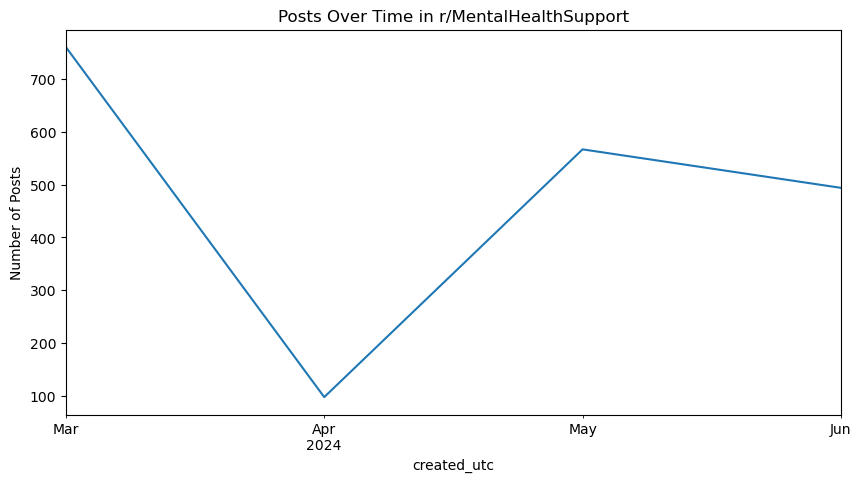

Time series plot generated successfully.

Descriptive Statistics for r/MentalHealthSupport:
Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers
count   1918.000000  1918.000000  1918.000000          1918.000000
mean       2.164234     2.942524     0.127612             0.000064
std        5.404613     4.884876     0.356346             0.000106
min        0.000000     0.000000     0.000000             0.000000
25%        0.000000     1.000000     0.000000             0.000022
50%        0.000000     2.000000     0.000000             0.000043
75%        2.000000     3.000000     0.000000             0.000065
max      154.000000   159.595960     3.826087             0.003447

Token Count Statistics:
 count    1920.000000
mean       91.085938
std        62.834949
min         1.000000
25%        40.750000
50%        74.500000
75%       133.500000
max       268.000000
Name: tokens, dtype: float64

Most Common Words:
 [('like', 3088), ('feel', 2844), ('kno

In [13]:
# r/MentalHealthSupport subreddit
mental_health_support_numerical_stats, mental_health_support_token_count_stats, mental_health_support_common_words = analyze_subreddit(mental_health_support_df)
mental_health_support_sentiment_stats, mental_health_support_sentiment_category_counts = analyze_sentiments(mental_health_support_df)
mental_health_support_topics = topic_modeling(mental_health_support_df['tokens'].tolist())

# word cloud for r/MentalHealthSupport subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealthSupport")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealthSupport")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealthSupport")

# time series analysis for r/MentalHealthSupport subreddit
mental_health_support_df.reset_index(inplace=True) #reset index
plot_time_series(mental_health_support_df, "Posts Over Time in r/MentalHealthSupport")

# statistics for r/MentalHealthSupport subreddit
print("\nDescriptive Statistics for r/MentalHealthSupport:")
print("Numerical Statistics:\n", mental_health_support_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_support_token_count_stats)
print("\nMost Common Words:\n", mental_health_support_common_words)
print("\nSentiment Statistics:\n", mental_health_support_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_support_sentiment_category_counts)

In [14]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['receive', 'idea', 'plan', 'see', 'fact', 'emotionally', 'nice', 'real', 'change', 'everything', 'change', 'life', 'anymore', 'inside', 'know', 'bottle', 'constant', 'feel', 'hang', 'breakdown']

Sampled Neutral Words:
['similar', 'play', 'advice', 'see', 'marriage', 'maybe', 'youtube', 'cop', 'crazy', 'etc', 'good', 'verbal', 'year', 'start', 'back', 'try', 'list', 'aimed', 'like', 'wan']

Sampled Negative Words:
['try', 'person', 'downhill', 'shut', 'disorder', 'press', 'small', 'really', 'speech', 'currently', 'exactly', 'nowhere', 'talked', 'hiding', 'know', 'hour', 'always', 'incredibly', 'started', 'cost']


r/MentalHealthSupport subreddit serves as a platform where users engage in discussions primarily focused on seeking and providing mental health support. With 1918 posts analyzed, the subreddit shows a consistent level of activity, averaging 2.16 comments per post and 2.94 upvotes. Posts often explore personal experiences and seek advice, reflected in common words like "feel," "know," and "life." Sentiment analysis reveals a slight negative skew with a mean score of -0.069, indicating a focus on expressing challenges and seeking empathetic responses. The community's engagement metrics, including token counts and sentiment distribution, highlight a space where users openly discuss mental health issues, emphasizing emotional support and mutual understanding.


### r/MentalHealth subreddit

Sentiment analysis completed successfully.
Topic modeling completed successfully.


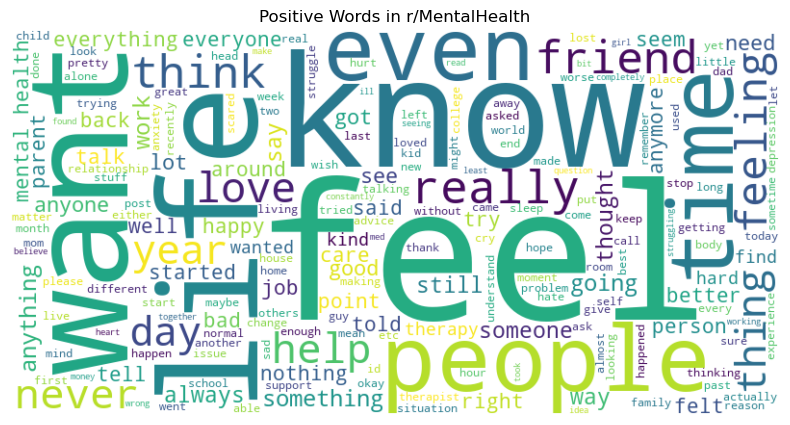

Word cloud generated successfully.


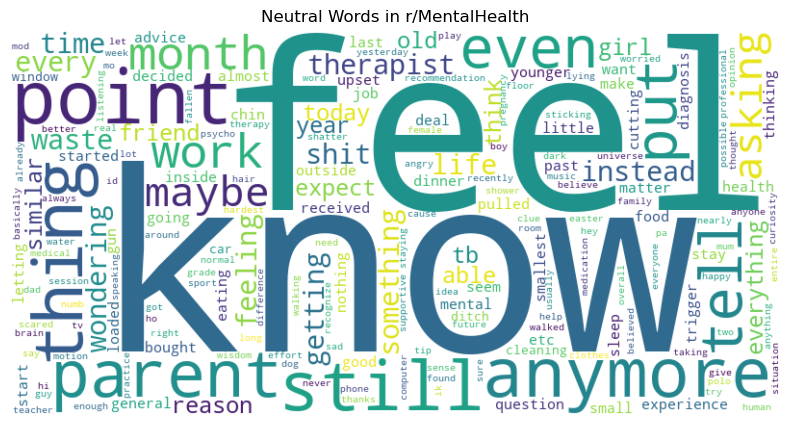

Word cloud generated successfully.


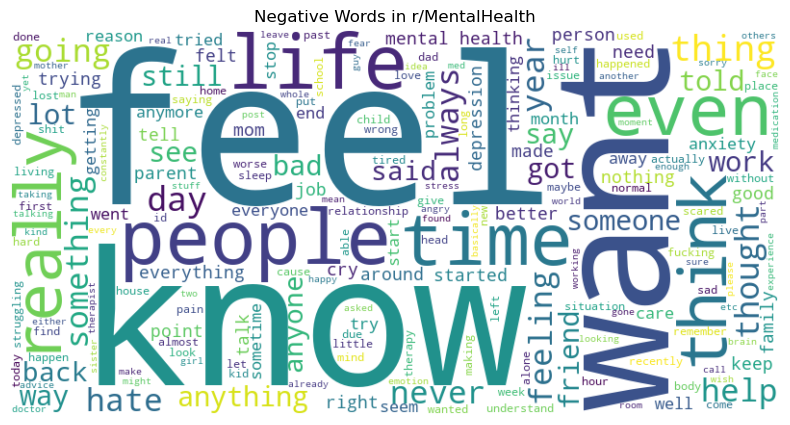

Word cloud generated successfully.


/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_1833/760322041.py:130: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


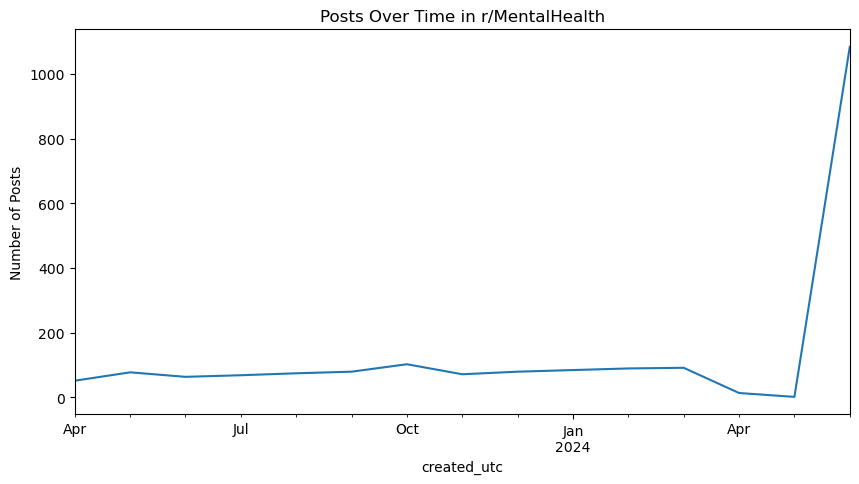

Time series plot generated successfully.

Descriptive Statistics for r/MentalHealth:
Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  2026.000000   2026.000000   2026.000000  2026.000000  2026.000000   
mean     56.056762      0.952567     32.046397    58.864358     2.807596   
std      93.746020      0.093561     56.496973    97.656802     6.402140   
min       0.000000      0.280000      0.000000     0.000000     0.000000   
25%       1.000000      0.950000      1.000000     1.000000     0.000000   
50%      13.000000      0.990000      8.000000    13.414894     0.469697   
75%      70.000000      1.000000     42.000000    73.747947     2.625905   
max     922.000000      1.000000    616.000000   940.816327    61.487179   

       upvotes/subscribers  
count          2026.000000  
mean              0.000125  
std               0.000208  
min               0.000000  
25%               0.000002  
50%               0.000029  
75% 

In [15]:
# r/MentalHealth subreddit
mental_health_numerical_stats, mental_health_token_count_stats, mental_health_common_words = analyze_subreddit(mental_health_df)
mental_health_sentiment_stats, mental_health_sentiment_category_counts = analyze_sentiments(mental_health_df)
mental_health_topics = topic_modeling(mental_health_df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealth")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealth")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealth")

# time series analysis for r/MentalHealth subreddit
mental_health_df.reset_index(inplace=True) #reset index
plot_time_series(mental_health_df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for r/MentalHealth:")
print("Numerical Statistics:\n", mental_health_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_token_count_stats)
print("\nMost Common Words:\n", mental_health_common_words)
print("\nSentiment Statistics:\n", mental_health_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_sentiment_category_counts)

In [16]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['daytime', 'others', 'may', 'hope', 'able', 'since', 'career', 'time', 'better', 'way', 'hit', 'feeling', 'art', 'want', 'side', 'point', 'around', 'wrong', 'answer', 'free']

Sampled Neutral Words:
['still', 'letting', 'matter', 'clue', 'going', 'dinner', 'overall', 'month', 'pulled', 'matter', 'advice', 'end', 'music', 'point', 'put', 'every', 'try', 'wish', 'clothes', 'stay']

Sampled Negative Words:
['happiness', 'thought', 'think', 'angry', 'toll', 'rap', 'far', 'since', 'resource', 'sister', 'nobody', 'conversation', 'really', 'alcohol', 'compromise', 'afraid', 'stop', 'mode', 'feel', 'play']


r/MentalHealth subreddit caters to broader discussions surrounding mental health, encompassing 2026 posts with higher average engagement compared to r/MentalHealthSupport. Each post averages 32.05 comments and 58.86 upvotes, indicating active participation and community interaction. Common words such as "like," "feel," and "know" underscore the subreddit's focus on personal experiences and broader social implications of mental health. Sentiment analysis shows a more balanced distribution with a mean score of -0.029, suggesting a mix of positive and negative expressions. The subreddit serves as a platform for both personal sharing and professional insights, fostering a supportive environment where users discuss a wide range of mental health topics with varying emotional tones.

### combined subreddits (r/MentalHealthSupport  and r/MentalHealth)

In [17]:
# combine both df into one
mental_health_support_df.reset_index(inplace=True)
mental_health_df.reset_index(inplace=True)

df = pd.concat([mental_health_support_df, 
                mental_health_df], 
               ignore_index=True)

# save processed dataframes to CSV files
df.to_csv('data/reddit_posts_cleaned.csv', index=False)
mental_health_support_df.to_csv('data/mental_health_support_posts_cleaned.csv', index=False)
mental_health_df.to_csv('data/mental_health_posts_cleaned.csv', index=False)

Sentiment analysis completed successfully.
Topic modeling completed successfully.


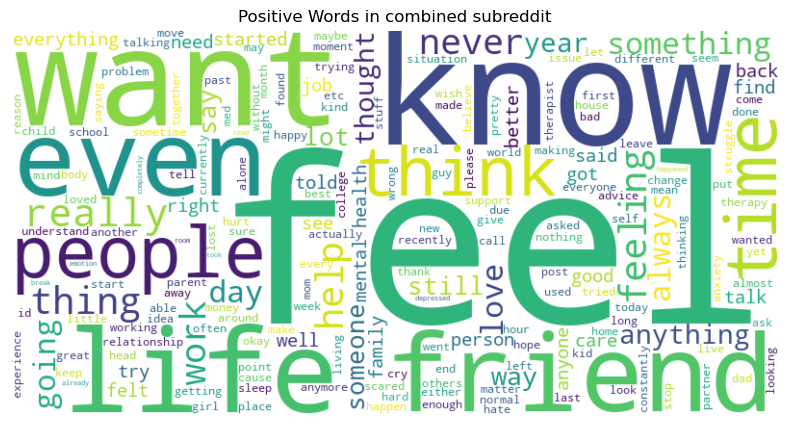

Word cloud generated successfully.


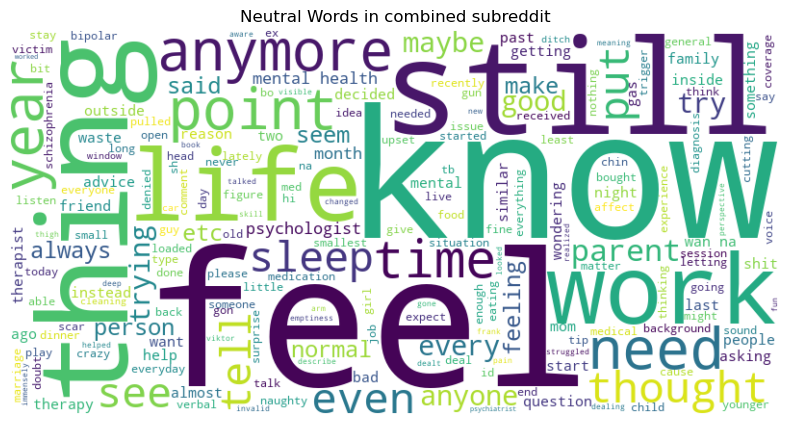

Word cloud generated successfully.


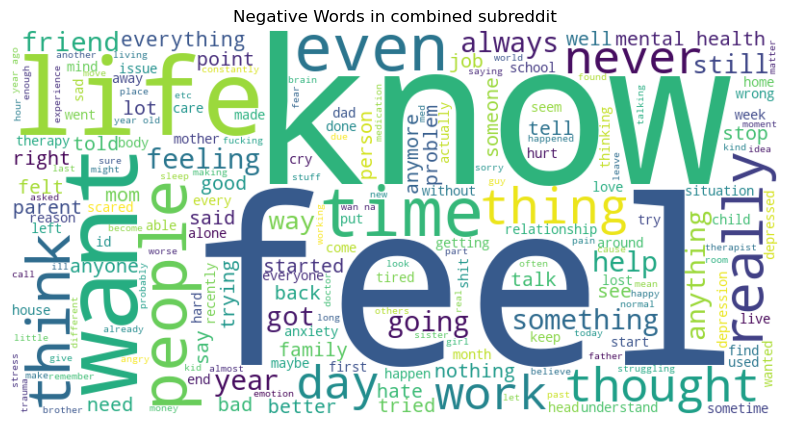

Word cloud generated successfully.


/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_1833/760322041.py:130: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


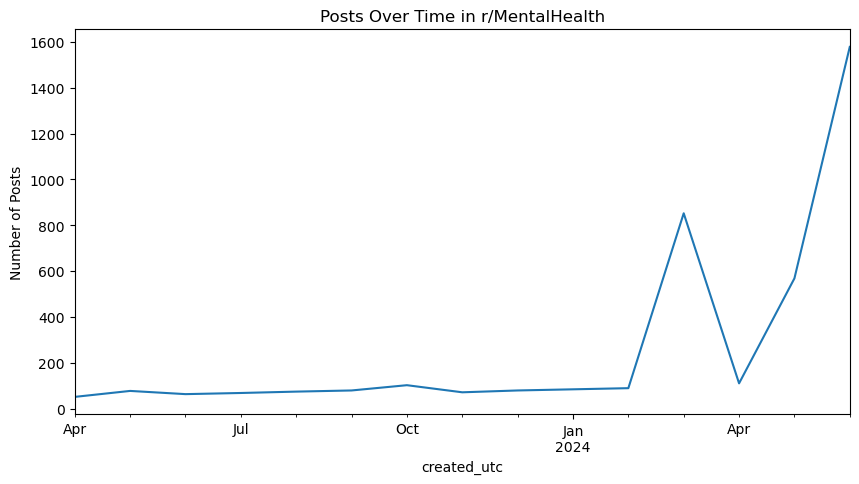

Time series plot generated successfully.

Descriptive Statistics for combined subreddit:
Numerical Statistics:
                          created_utc        index  num_comments      upvotes  \
count                           3945  3946.000000   3944.000000  3944.000000   
mean   2024-03-25 16:19:38.744486656   986.711860     17.514452    31.669105   
min              2023-04-06 07:17:59     0.000000      0.000000     0.000000   
25%              2024-03-06 02:48:20   493.000000      0.000000     1.000000   
50%              2024-05-18 17:43:26   986.000000      2.000000     2.000000   
75%              2024-06-13 18:59:14  1479.000000     13.000000    30.154639   
max              2024-06-17 04:45:52  2025.000000    616.000000   940.816327   
std                              NaN   570.859508     43.319617    75.437728   

         downvotes  upvotes/subscribers  
count  3944.000000          3944.000000  
mean      1.504298             0.000095  
min       0.000000             0.000000  

In [18]:
# combined subreddit
df_numerical_stats, df_token_count_stats, df_common_words = analyze_subreddit(df)
df_sentiment_stats, df_sentiment_category_counts = analyze_sentiments(df)
df_topics = topic_modeling(df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'],df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in combined subreddit")
generate_word_cloud(neutral_words, "Neutral Words in combined subreddit")
generate_word_cloud(negative_words, "Negative Words in combined subreddit")

# time series analysis for combined subreddit
plot_time_series(df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for combined subreddit:")
print("Numerical Statistics:\n", df_numerical_stats)
print("\nToken Count Statistics:\n", df_token_count_stats)
print("\nMost Common Words:\n", df_common_words)
print("\nSentiment Statistics:\n", df_sentiment_stats)
print("\nSentiment Category Counts:\n", df_sentiment_category_counts)

In [19]:
# extract common words
sample_size = 50  

positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['anyone', 'leave', 'nurse', 'never', 'mess', 'reaching', 'feel', 'sex', 'front', 'foot', 'influencing', 'deal', 'ruthless', 'private', 'time', 'later', 'ho', 'friend', 'know', 'pc', 'spur', 'left', 'know', 'started', 'understand', 'anger', 'give', 'medication', 'feel', 'bit', 'feel', 'maintain', 'know', 'even', 'week', 'pick', 'week', 'started', 'specialist', 'therapy', 'feeling', 'although', 'love', 'course', 'like', 'self', 'feel', 'thinking', 'made', 'second']

Sampled Neutral Words:
['getting', 'life', 'need', 'inside', 'fee', 'seen', 'fine', 'youtube', 'ago', 'moved', 'tip', 'sh', 'made', 'got', 'nothing', 'person', 'naughty', 'know', 'advice', 'crazy', 'thanks', 'small', 'shit', 'schizophrenia', 'coverage', 'recently', 'younger', 'school', 'mostly', 'sound', 'enough', 'cleaning', 'ever', 'food', 'chin', 'difference', 'general', 'recognize', 'denied', 'hair', 'tb', 'recently', 'reason', 'sleep', 'normal', 'bad', 'heavy', 'sense', 'feel', 'thought']

Sampl

The combined dataset of r/MentalHealthSupport and r/MentalHealth subreddits offers a comprehensive view of mental health discussions on Reddit, encompassing 3946 posts. This dataset reflects diverse engagement metrics, with an average of 17.51 comments and 31.67 upvotes per post. Commonly used words like "like," "feel," and "know" resonate across both communities, highlighting shared themes of personal reflection and seeking support. Sentiment analysis reveals an overall negative sentiment trend with a mean score of -0.049, indicative of users expressing challenges and seeking understanding within supportive environments. The combined subreddit dataset underscores the importance of online communities in providing a platform for individuals to share experiences, seek advice, and find solidarity in navigating mental health issues.

In [20]:
df.sample(10)

,index,title,score,upvote_ratio,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers,tokens,sentiment,sentiment_category
created_utc,,,,,,,,,,,,,,,,
2024-06-06 14:21:14,1848,I can't fucking find a therapist who can help me,15,0.89,old culturally different besides moving month ...,MentalHealthSupport,ComfortMeFag,False,/r/MentalHealthSupport/comments/1d9jd2z/i_cant...,14.0,16.853933,1.853933,0.000364,"[old, culturally, different, besides, moving, ...","{'neg': 0.183, 'neu': 0.699, 'pos': 0.118, 'co...",negative
2024-01-16 10:30:47,745,"People with bipolar/ADHD, what is your job/car...",47,0.94,disorder trying figure next move point money h...,mentalhealth,Inside_Original_4182,False,/r/mentalhealth/comments/197zubs/people_with_b...,152.0,50.000000,3.000000,0.000107,"[disorder, trying, figure, next, move, point, ...","{'neg': 0.103, 'neu': 0.613, 'pos': 0.284, 'co...",positive
2024-06-16 13:15:15,1140,I often worry that I will never fully get bett...,1,1.0,part anxiety actually worry mental health spen...,mentalhealth,Exact-Government-609,False,/r/mentalhealth/comments/1dh7d05/i_often_worry...,1.0,1.000000,0.000000,0.000002,"[part, anxiety, actually, worry, mental, healt...","{'neg': 0.172, 'neu': 0.712, 'pos': 0.116, 'co...",negative
2024-01-11 17:41:38,292,Bf cheated on me and now idk what the hell to do,110,0.95,found new year eve bf cheating behind bf back ...,mentalhealth,Formal_Historian_799,False,/r/mentalhealth/comments/1947ige/bf_cheated_on...,65.0,115.789474,5.789474,0.000247,"[found, new, year, eve, bf, b, cheating, behin...","{'neg': 0.141, 'neu': 0.743, 'pos': 0.116, 'co...",negative
2023-10-08 20:11:58,565,"Guys, what do you immediately do when depressi...",63,0.97,hello guy know difficult comfort action come d...,mentalhealth,lylahey,False,/r/mentalhealth/comments/1738o2n/guys_what_do_...,80.0,64.948454,1.948454,0.000138,"[hello, guy, know, difficult, comfort, action,...","{'neg': 0.279, 'neu': 0.447, 'pos': 0.274, 'co...",negative
2023-09-12 12:29:42,462,did i mess up?,74,0.96,au friend text group chat last night saying ps...,mentalhealth,prof-cannabalist,False,/r/mentalhealth/comments/16gq3zr/did_i_mess_up/,14.0,77.083333,3.083333,0.000164,"[au, friend, text, group, chat, last, night, s...","{'neg': 0.276, 'neu': 0.495, 'pos': 0.229, 'co...",negative
2024-06-13 13:55:02,970,Over thinking?,1,1.0,conversation partner told laying bed going sle...,MentalHealthSupport,Secret_Reward_5263,False,/r/MentalHealthSupport/comments/1dezku5/over_t...,0.0,1.000000,0.000000,0.000022,"[conversation, partner, told, laying, bed, goi...","{'neg': 0.09, 'neu': 0.845, 'pos': 0.065, 'com...",positive
2024-06-04 01:14:02,1238,Is there anyone out there?,1,1.0,anyone alone scared head loud screaming end fi...,MentalHealthSupport,ReckonedForce,False,/r/MentalHealthSupport/comments/1d7kz2u/is_the...,0.0,1.000000,0.000000,0.000022,"[anyone, alone, scared, head, loud, screaming,...","{'neg': 0.788, 'neu': 0.212, 'pos': 0.0, 'comp...",negative
2024-05-19 23:02:39,1654,I’m slowly going ceazy,1,1.0,r mig ko coherent hand shake butt god turned b...,MentalHealthSupport,Slendydude,False,/r/MentalHealthSupport/comments/1cw0yke/im_slo...,1.0,1.000000,0.000000,0.000022,"[r, mig, ko, coherent, hand, shake, butt, god,...","{'neg': 0.117, 'neu': 0.551, 'pos': 0.331, 'co...",positive


Analyzing engagement metrics, content characteristics, and sentiment dynamics helps illuminate the role of online forums in supporting mental well-being and advocating for destigmatization. These insights are crucial for community management, content strategy, and ensuring these platforms continue to serve as safe spaces for open dialogue and support.